# Volcanic Evacuation Analysis

This script performs a comprehensive analysis of evacuation routes from volcanoes,
calculating optimal paths and travel times from various points to safe zones under
different walking speed scenarios.

The analysis is broken down into sequential steps that can be executed one by one
to better understand each part of the process.

# IMPORTING REQUIRED PACKAGES
 First, let's import all the packages we need for the analysis


In [1]:
import pandas as pd
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from config import *
from io_utils import (read_shapefile, read_raster, save_raster, 
                     save_analysis_report, save_metrics_csv)
from grid_utils import (coords_to_raster, process_raster, 
                       calculate_distance_from_summit, raster_coord_to_map_coords, to_1d)
from path_utils import build_adjacency_matrix, reconstruct_path
from analysis import (run_dijkstra_analysis, process_travel_times, 
                     analyze_safe_zones)
from visualization import (plot_travel_time_comparison, create_cost_surface_subplots,
                          load_raster, create_decomposition_table, create_final_evacuation_table)
from pyproj import CRS, Transformer
from decomposition import run_decomposition_analysis

In [2]:
# Initialize dictionaries to store results
all_results = {}
dataset_info = {}
min_coords_all = {}

print("All required packages have been imported.")
print(f"The analysis will use {len(COST_PATHS)} cost datasets: {list(COST_PATHS.keys())}")
print(f"Walking speeds: {WALKING_SPEEDS}")
print(f"Safe zone distances: {SAFE_ZONE_DISTANCES}")

All required packages have been imported.
The analysis will use 4 cost datasets: ['final', 'modify_landcover', 'walking_speed', 'base_cost']
Walking speeds: {'slow': 0.91, 'medium': 1.22, 'fast': 1.52}
Safe zone distances: [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]


## Loading Geographic Data

Before we can analyze evacuation routes, we need to load the geographic data that 
defines the area of interest:

1. **Summit Location**: The point representing the volcano's peak
2. **Camping Spots**: Locations where people may be staying (evacuation sources)
3. **Hiking Paths**: Existing trails that could be used for evacuation

These datasets are stored as shapefiles and are loaded using the `read_shapefile` 
function from our utilities module.

In [3]:
print("\n=== SECTION 1: LOADING GEOGRAPHIC DATA ===")
start_time = time.time()

# Read common shapefiles
print("Reading shapefiles...")
summit_gdf = read_shapefile(SUMMIT_PATH)
camp_gdf = read_shapefile(CAMP_SPOT_PATH)
hiking_gdf = read_shapefile(HIKING_PATH)

end_time = time.time()
print(f"Geographic data loaded in {end_time - start_time:.2f} seconds")

# Display basic information about the loaded data
print(f"Summit data: {summit_gdf.shape[0]} points loaded")
print(f"Camp data: {camp_gdf.shape[0]} points loaded")
print(f"Hiking path data: {hiking_gdf.shape[0]} features loaded")



=== SECTION 1: LOADING GEOGRAPHIC DATA ===
Reading shapefiles...
Reading shapefile: summit_awu_correct_proj_final.shp
Reading shapefile: campspot_awu_correct_proj_final.shp
Reading shapefile: hikingpath_awu_buffer_correctproj_final.shp
Geographic data loaded in 0.05 seconds
Summit data: 1 points loaded
Camp data: 1 points loaded
Hiking path data: 1 features loaded


## Processing Cost Datasets

Now we'll process each cost raster dataset. Cost rasters represent the "difficulty" 
of traversing different terrain types. We have multiple cost datasets to compare
different scenarios:

1. **Final**: Cost raster with original LandCover
2. **Modified Landcover**: Cost raster with modified Landcover
3. **Walking Speed**: Cost raster based solely on Slope
4. **Base Cost**:Cost raster based solely on Landcover

For each dataset, we:
1. Read the cost raster from disk
2. Expand it to 8 directional bands if needed (for 8-direction path finding)
3. Convert geographic coordinates to raster indices
4. Build an adjacency matrix representing possible movements
5. Run Dijkstra's algorithm to find optimal paths
6. Save the resulting distance rasters

In [4]:
for dataset_key, current_cost_path in COST_PATHS.items():
    print(f"\n=== PROCESSING COST DATASET: {dataset_key} ===")
    process_start_time = time.time()
    
    print(f"Step 1: Reading cost raster from {os.path.basename(current_cost_path)}")
    cost_array, meta, transform, nodata, bounds, resolution = read_raster(current_cost_path)
    print(f"Cost raster shape: {cost_array.shape}")
    
    # Expand single-band raster to 8 directional bands if needed
    if cost_array.shape[0] == 1:
        print(f"Step 2: Expanding single-band raster to 8 directional bands")
        single_band = cost_array[0]
        expanded = np.zeros((8, *single_band.shape), dtype=single_band.dtype)
        for i in range(8):
            expanded[i] = single_band.copy()
            if i >= 4:  # Diagonal directions
                expanded[i] *= np.sqrt(2)
        cost_array = expanded
        print(f"Expanded cost array shape: {cost_array.shape}")
    else:
        print(f"Step 2: Cost raster already has {cost_array.shape[0]} bands, no expansion needed")
    
    # Convert coordinates to raster indices
    print("Step 3: Converting geographic coordinates to raster indices")
    summit_rc = coords_to_raster(summit_gdf, transform, bounds, resolution)
    camp_rc = coords_to_raster(camp_gdf, transform, bounds, resolution)
    source_coords = [summit_rc[0]] + camp_rc
    print(f"Summit raster coordinates: {summit_rc[0]}")
    print(f"Camp raster coordinates: {camp_rc}")
    
    # Build adjacency matrix
    print("Step 4: Building adjacency matrix for path finding")
    adj_start_time = time.time()
    bands, rows, cols = cost_array.shape
    graph_csr = build_adjacency_matrix(cost_array, rows, cols, DIRECTIONS)
    adj_end_time = time.time()
    print(f"Adjacency matrix built in {adj_end_time - adj_start_time:.2f} seconds")
    print(f"Matrix shape: {graph_csr.shape}, Non-zero elements: {graph_csr.nnz}")
    
    # Run Dijkstra's algorithm
    print("Step 5: Running Dijkstra's algorithm for shortest paths")
    dijkstra_start_time = time.time()
    source_nodes = [to_1d(r, c, cols) for (r, c) in source_coords]
    distances, predecessors = run_dijkstra_analysis(graph_csr, source_nodes)
    dijkstra_end_time = time.time()
    print(f"Dijkstra's algorithm completed in {dijkstra_end_time - dijkstra_start_time:.2f} seconds")
    
    # Save base cost distance rasters
    print("Step 6: Saving base cost distance rasters")
    for i, source_name in enumerate(SOURCE_NAMES):
        source_distance = distances[i, :].reshape(rows, cols)
        source_distance[np.isinf(source_distance)] = -1
        out_filename = f'cost_distance_{source_name}_{dataset_key}.tif'
        save_raster(os.path.join(DATA_FOLDER, out_filename), source_distance, meta)
        print(f"Saved: {out_filename}")
    
    # Store dataset info for later use
    dataset_info[dataset_key] = {
        "pred_summit": predecessors[0],
        "rows": rows,
        "cols": cols,
        "transform": transform,
        "meta": meta,  # Add this line to store the metadata
        "summit_raster_coords": summit_rc[0]
    }
    
    process_end_time = time.time()
    print(f"Dataset {dataset_key} processed in {process_end_time - process_start_time:.2f} seconds")


=== PROCESSING COST DATASET: final ===
Step 1: Reading cost raster from Awu_inverted_cost_8_directions_original.tif
Reading raster: Awu_inverted_cost_8_directions_original.tif
Cost raster shape: (8, 400, 401)
Step 2: Cost raster already has 8 bands, no expansion needed
Step 3: Converting geographic coordinates to raster indices
Converting coordinates to raster indices...
Converting coordinates to raster indices...
Summit raster coordinates: (198, 200)
Camp raster coordinates: [(215, 209)]
Step 4: Building adjacency matrix for path finding

Building adjacency matrix...


Processing rows: 100%|███████████████████████████████████████████████████████████████| 400/400 [00:13<00:00, 29.64it/s]


Adjacency matrix built in 13.78 seconds
Matrix shape: (160400, 160400)
Number of non-zero elements: 1278398
Adjacency matrix built in 13.83 seconds
Matrix shape: (160400, 160400), Non-zero elements: 1278398
Step 5: Running Dijkstra's algorithm for shortest paths

Running Dijkstra's algorithm...
Dijkstra's algorithm completed in 0.15 seconds
Dijkstra's algorithm completed in 0.15 seconds
Step 6: Saving base cost distance rasters
Saved: cost_distance_summit_final.tif
Saved: cost_distance_camp1_final.tif
Dataset final processed in 14.51 seconds

=== PROCESSING COST DATASET: modify_landcover ===
Step 1: Reading cost raster from Awu_inverted_cost_8_directions_modified.tif
Reading raster: Awu_inverted_cost_8_directions_modified.tif
Cost raster shape: (8, 400, 401)
Step 2: Cost raster already has 8 bands, no expansion needed
Step 3: Converting geographic coordinates to raster indices
Converting coordinates to raster indices...
Converting coordinates to raster indices...
Summit raster coordina

Processing rows: 100%|███████████████████████████████████████████████████████████████| 400/400 [00:14<00:00, 27.19it/s]


Adjacency matrix built in 15.05 seconds
Matrix shape: (160400, 160400)
Number of non-zero elements: 1278398
Adjacency matrix built in 15.11 seconds
Matrix shape: (160400, 160400), Non-zero elements: 1278398
Step 5: Running Dijkstra's algorithm for shortest paths

Running Dijkstra's algorithm...
Dijkstra's algorithm completed in 0.18 seconds
Dijkstra's algorithm completed in 0.18 seconds
Step 6: Saving base cost distance rasters
Saved: cost_distance_summit_modify_landcover.tif
Saved: cost_distance_camp1_modify_landcover.tif
Dataset modify_landcover processed in 15.84 seconds

=== PROCESSING COST DATASET: walking_speed ===
Step 1: Reading cost raster from inverted_Slopecost_8_directions_Awu_OriginalLandcover.tif
Reading raster: inverted_Slopecost_8_directions_Awu_OriginalLandcover.tif
Cost raster shape: (8, 400, 401)
Step 2: Cost raster already has 8 bands, no expansion needed
Step 3: Converting geographic coordinates to raster indices
Converting coordinates to raster indices...
Converti

Processing rows: 100%|███████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 26.41it/s]


Adjacency matrix built in 15.48 seconds
Matrix shape: (160400, 160400)
Number of non-zero elements: 1278398
Adjacency matrix built in 15.54 seconds
Matrix shape: (160400, 160400), Non-zero elements: 1278398
Step 5: Running Dijkstra's algorithm for shortest paths

Running Dijkstra's algorithm...
Dijkstra's algorithm completed in 0.17 seconds
Dijkstra's algorithm completed in 0.17 seconds
Step 6: Saving base cost distance rasters
Saved: cost_distance_summit_walking_speed.tif
Saved: cost_distance_camp1_walking_speed.tif
Dataset walking_speed processed in 16.17 seconds

=== PROCESSING COST DATASET: base_cost ===
Step 1: Reading cost raster from invert_landcovercost_original_Awu.tif
Reading raster: invert_landcovercost_original_Awu.tif
Cost raster shape: (1, 400, 401)
Step 2: Expanding single-band raster to 8 directional bands
Expanded cost array shape: (8, 400, 401)
Step 3: Converting geographic coordinates to raster indices
Converting coordinates to raster indices...
Converting coordinate

Processing rows: 100%|███████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.61it/s]


Adjacency matrix built in 16.00 seconds
Matrix shape: (160400, 160400)
Number of non-zero elements: 1278398
Adjacency matrix built in 16.06 seconds
Matrix shape: (160400, 160400), Non-zero elements: 1278398
Step 5: Running Dijkstra's algorithm for shortest paths

Running Dijkstra's algorithm...
Dijkstra's algorithm completed in 0.16 seconds
Dijkstra's algorithm completed in 0.16 seconds
Step 6: Saving base cost distance rasters
Saved: cost_distance_summit_base_cost.tif
Saved: cost_distance_camp1_base_cost.tif
Dataset base_cost processed in 16.69 seconds


## Calculating Travel Times

Now that we have the base cost distances, we can calculate actual travel times for
different walking speeds. The travel time represents how long it would take to reach
any point from each source location.

For each dataset, walking speed, and source point combination, we:
1. Load the corresponding cost distance raster
2. Process it to calculate travel times in hours
3. Store both the 2D array and a flattened version for analysis

We consider three walking speeds as defined in the config:
- Slow: 0.91 m/s (3.3 km/h)
- Medium: 1.22 m/s (4.4 km/h)
- Fast: 1.52 m/s (5.5 km/h)

In [5]:
# Process travel times for each dataset
for dataset_key in COST_PATHS.keys():
    print(f"\n=== CALCULATING TRAVEL TIMES FOR: {dataset_key} ===")
    travel_time_start = time.time()
    
    # Process travel times for each walking speed and source
    travel_time_data = {}
    for speed_name, speed_value in WALKING_SPEEDS.items():
        print(f"Processing {speed_name} walking speed ({speed_value} m/s)")
        travel_time_data[speed_name] = {}
        
        for source_name in SOURCE_NAMES:
            print(f"  Source: {source_name}")
            base_filename = f'cost_distance_{source_name}_{dataset_key}.tif'
            base_path = os.path.join(DATA_FOLDER, base_filename)
            
            # Load the base cost distance and convert to travel time
            travel_time_array = process_travel_times(
                base_path, source_name, dataset_key, speed_name, speed_value, 
                meta=dataset_info[dataset_key].get("meta", None)
            )
            
            # Store the travel time data
            travel_time_data[speed_name][source_name] = {
                'cost_array': travel_time_array,
                'cost_array_flat': travel_time_array.ravel()
            }
            print(f"  Travel time range: {np.nanmin(travel_time_array):.2f} to {np.nanmax(travel_time_array):.2f} hours")
    
    # Calculate distance from summit for each cell
    print("Calculating distance from summit for safe zone analysis")
    summit_rc = dataset_info[dataset_key]["summit_raster_coords"]
    rows = dataset_info[dataset_key]["rows"]
    cols = dataset_info[dataset_key]["cols"]
    distance_from_summit = calculate_distance_from_summit(summit_rc, rows, cols)
    print(f"Maximum distance from summit: {np.max(distance_from_summit):.2f} meters")
    
    # Analyze safe zones
    print("Analyzing minimum travel times within safe zones")
    results, min_coords = analyze_safe_zones(
        distance_from_summit, travel_time_data, SAFE_ZONE_DISTANCES, SOURCE_NAMES
    )
    
    # Save results
    print("Saving analysis results")
    base_name = f"safe_zone_travel_time_{dataset_key}"
    save_analysis_report(
        os.path.join(DATA_FOLDER, f"{base_name}_report.txt"),
        results, min_coords, SOURCE_NAMES, WALKING_SPEEDS, SAFE_ZONE_DISTANCES
    )
    save_metrics_csv(
        os.path.join(DATA_FOLDER, f"{base_name}_metrics.csv"),
        results, min_coords, SOURCE_NAMES, WALKING_SPEEDS, SAFE_ZONE_DISTANCES
    )
    
    # Store results for comparison
    all_results[dataset_key] = results
    min_coords_all[dataset_key] = min_coords
    
    travel_time_end = time.time()
    print(f"Travel times for {dataset_key} calculated in {travel_time_end - travel_time_start:.2f} seconds")


=== CALCULATING TRAVEL TIMES FOR: final ===
Processing slow walking speed (0.91 m/s)
  Source: summit
Processing travel times for summit at slow speed...
  Travel time range: 0.00 to 6942791.50 hours
  Source: camp1
Processing travel times for camp1 at slow speed...
  Travel time range: 0.00 to 6942790.50 hours
Processing medium walking speed (1.22 m/s)
  Source: summit
Processing travel times for summit at medium speed...
  Travel time range: 0.00 to 5178640.00 hours
  Source: camp1
Processing travel times for camp1 at medium speed...
  Travel time range: 0.00 to 5178639.00 hours
Processing fast walking speed (1.52 m/s)
  Source: summit
Processing travel times for summit at fast speed...
  Travel time range: 0.00 to 4156540.00 hours
  Source: camp1
Processing travel times for camp1 at fast speed...
  Travel time range: 0.00 to 4156539.25 hours
Calculating distance from summit for safe zone analysis
Calculating distance from summit...
Maximum distance from summit: 28355.07 meters
Anal

## Decomposition Analysis

Now we'll analyze what factors contribute most to the evacuation time:

1. **Slope Contribution**: How much the terrain's steepness affects travel time
2. **Land Cover Contribution**: How much the land cover (forests, fields, etc.) affects travel time

The decomposition analysis helps understand which factors most impact evacuation routes,
which can guide planning and mitigation efforts.


=== SECTION 4: DECOMPOSITION ANALYSIS ===
Running decomposition analysis...

=== Running Decomposition Analysis ===
Reading raster: Awu_inverted_cost_8_directions_original.tif
Reading raster: inverted_Slopecost_8_directions_Awu_OriginalLandcover.tif
Reading raster: invert_landcovercost_original_Awu.tif
Expanding single-band base_cost raster to 8 directions...
Decomposition analysis for 'final' dataset, source: summit, speed: medium
Creating decomposition table visualization


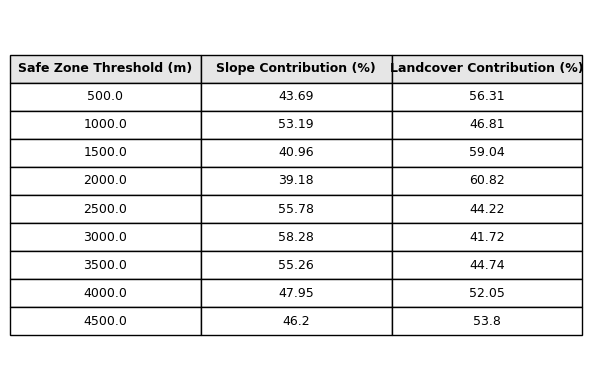

Decomposition analysis completed in 1.10 seconds
Results saved to: C:\Users\Mojan\Desktop\RA Volcano\python_results\decomposition_table.png

Decomposition Results Summary:
Safe Zone 500m: Slope 43.7%, Land Cover 56.3%
Safe Zone 1000m: Slope 53.2%, Land Cover 46.8%
Safe Zone 1500m: Slope 41.0%, Land Cover 59.0%
Safe Zone 2000m: Slope 39.2%, Land Cover 60.8%
Safe Zone 2500m: Slope 55.8%, Land Cover 44.2%
Safe Zone 3000m: Slope 58.3%, Land Cover 41.7%
Safe Zone 3500m: Slope 55.3%, Land Cover 44.7%
Safe Zone 4000m: Slope 48.0%, Land Cover 52.0%
Safe Zone 4500m: Slope 46.2%, Land Cover 53.8%


<Figure size 640x480 with 0 Axes>

In [6]:
print("\n=== SECTION 4: DECOMPOSITION ANALYSIS ===")
decomp_start_time = time.time()

# Run decomposition analysis
print("Running decomposition analysis...")
decomposition_data = run_decomposition_analysis(dataset_info, min_coords_all)

# Create and save the decomposition table
print("Creating decomposition table visualization")
table_output_path = os.path.join(DATA_FOLDER, "decomposition_table.png")
df_decomp = create_decomposition_table(decomposition_data, table_output_path)

# Also save as CSV
df_decomp.to_csv(os.path.join(DATA_FOLDER, "decomposition_table.csv"), index=False)

decomp_end_time = time.time()
print(f"Decomposition analysis completed in {decomp_end_time - decomp_start_time:.2f} seconds")
print(f"Results saved to: {table_output_path}")

# Show the decomposition results
print("\nDecomposition Results Summary:")
for row in decomposition_data:
    sz = row["Safe Zone Threshold (m)"]
    slope = row["Slope Contribution (%)"]
    landcover = row["Landcover Contribution (%)"]
    print(f"Safe Zone {sz}m: Slope {slope:.1f}%, Land Cover {landcover:.1f}%")


## Creating Visualizations

Finally, we'll create visualizations to help understand the results:

1. **Travel Time Comparison Plot**: Compares minimum travel times for different sources,
   walking speeds, and terrain scenarios

2. **Evacuation Path Visualization**: Shows optimal paths from the summit to different
   safe zones overlaid on cost surfaces

3. **Final Evacuation Table**: Summarizes evacuation times in a tabular format

These visualizations help emergency planners understand evacuation options and
identify the most efficient routes.


=== SECTION 5: CREATING VISUALIZATIONS ===
Creating travel time comparison plot...

Creating travel time comparison plot...


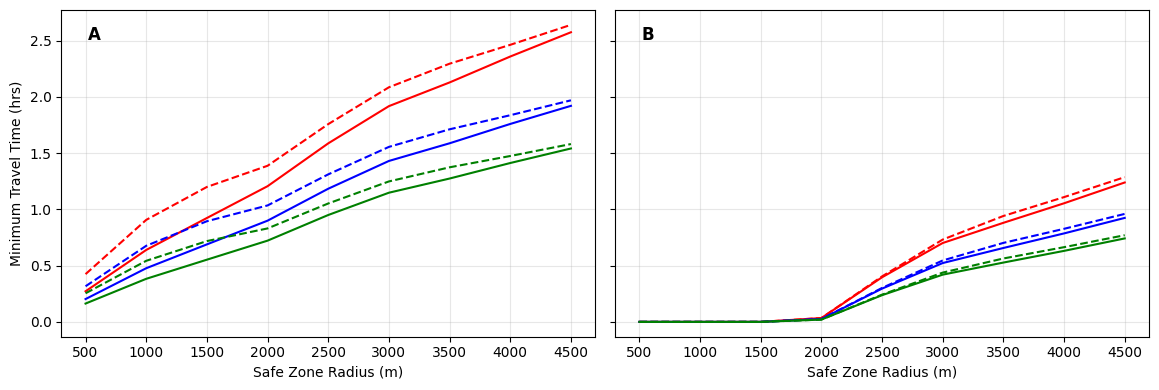

Travel time comparison plot created in 0.36 seconds
Travel time comparison plot saved
Processing evacuation paths...
Creating cost surface visualization...

Creating cost surface subplots...


C:\Users\Mojan\Desktop\RA Volcano\Python Code\github\visualization.py:382: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


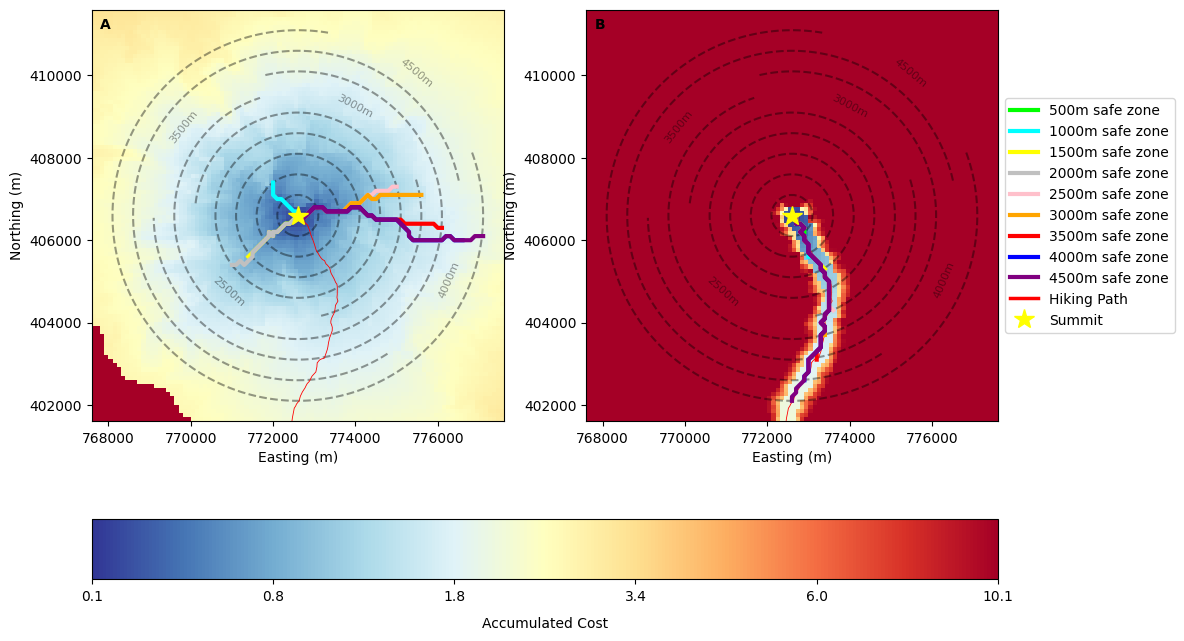

Cost surface subplots created in 0.98 seconds
Cost surface visualization saved to C:\Users\Mojan\Desktop\RA Volcano\python_results\cost_surface_with_paths_enhanced.png
Visualization completed in 2.21 seconds


In [8]:
print("\n=== SECTION 5: CREATING VISUALIZATIONS ===")
viz_start_time = time.time()

# Add a verbose flag to control detailed output
verbose = False  # Set to False to suppress detailed messages

# 1. Travel Time Comparison Plot
print("Creating travel time comparison plot...")
speed_colors = {
    'slow': 'red',
    'medium': 'blue',
    'fast': 'green'
}
comparison_fig = plot_travel_time_comparison(
    all_results, SAFE_ZONE_DISTANCES, SOURCE_NAMES, speed_colors
)
comparison_fig.savefig(
    os.path.join(DATA_FOLDER, "comparison_travel_time_by_source.png"), 
    dpi=300, bbox_inches='tight'
)
plt.close(comparison_fig)
print("Travel time comparison plot saved")

# 2. Process evacuation paths for visualization
print("Processing evacuation paths...")
selected_speed = 'medium'
evacuation_paths = {ds_key: {} for ds_key in dataset_info.keys()}

# Process paths for each dataset
for ds_key, info in dataset_info.items():
    if verbose:
        print(f"Processing paths for {ds_key}...")
    
    pred_summit = info["pred_summit"]
    rows, cols = info["rows"], info["cols"]
    summit_rc = info["summit_raster_coords"]
    summit_node = to_1d(summit_rc[0], summit_rc[1], cols)
    
    for sz in SAFE_ZONE_DISTANCES:
        target_coord = min_coords_all[ds_key][selected_speed][sz][0]
        if np.isnan(target_coord[0]) or np.isnan(target_coord[1]):
            if verbose:
                print(f"  No valid target for {sz}m safe zone")
            evacuation_paths[ds_key][sz] = []
            continue
        
        target_node = to_1d(int(target_coord[0]), int(target_coord[1]), cols)
        path_coords = reconstruct_path(pred_summit, summit_node, target_node, cols)
        evacuation_paths[ds_key][sz] = path_coords
        
        if verbose:
            print(f"  Path to {sz}m safe zone: {len(path_coords)} steps")

# 3. Create Cost Surface Visualization
print("Creating cost surface visualization...")

# Load cost rasters for visualization
cost_arrays = []
transforms = []
for ds_key in dataset_info.keys():
    if verbose:
        print(f"Loading cost raster for {ds_key}...")
    
    cost_raster_path = os.path.join(DATA_FOLDER, f'cost_distance_summit_{ds_key}_medium_hours.tif')
    cost_array, cost_meta = load_raster(cost_raster_path)
    cost_arrays.append(cost_array)
    transforms.append(cost_meta['transform'])

output_path = os.path.join(DATA_FOLDER, 'cost_surface_with_paths_enhanced.png')
create_cost_surface_subplots(
    dataset_info=dataset_info,
    cost_arrays=cost_arrays,
    transforms=transforms,
    evacuation_paths=evacuation_paths,
    summit_coords={k: v['summit_raster_coords'] for k, v in dataset_info.items()},
    safe_zone_distances=SAFE_ZONE_DISTANCES,
    hiking_gdf=hiking_gdf,
    output_path=output_path
)
print(f"Cost surface visualization saved to {output_path}")

# Display total time for visualization section
viz_end_time = time.time()
print(f"Visualization completed in {viz_end_time - viz_start_time:.2f} seconds")